In [2]:
%load_ext autoreload
%autoreload 2
%reload_ext watermark

import os

os.environ["PREFECT__FLOWS__CHECKPOINTING"] = "True"

import fsspec
import pandas as pd
import xarray as xr
import numpy as np
import cmip6_downscaling
import numpy as np
from xarray_schema import DataArraySchema, DatasetSchema

from cmip6_downscaling.data.observations import open_era5
from cmip6_downscaling.data.cmip import get_gcm, load_cmip
from dask.distributed import Client, LocalCluster
import warnings

warnings.filterwarnings("ignore")
import pytest
from cmip6_downscaling.analysis import analysis, metrics
from cmip6_downscaling.analysis.analysis import (
    qaqc_checks,
    grab_top_city_data,
    load_top_cities,
    get_seasonal,
    change_ds,
)
from cmip6_downscaling.analysis.plot import (
    plot_cdfs,
    plot_values_and_difference,
    plot_seasonal,
)  # , plot_each_step_bcsd
from cmip6_downscaling.analysis.qaqc import make_qaqc_ds
from cmip6_downscaling.methods.common.containers import BBox
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from carbonplan import styles
from cmip6_downscaling import config
from upath import UPath
import json

styles.mpl.set_theme(style='carbonplan_dark')

In [3]:
watermark -d -n -t -u -v -p cmip6_downscaling -h -m -g -r -b

Last updated: 2022-06-14 22:39:13

Python implementation: CPython
Python version       : 3.9.13
IPython version      : 8.4.0

cmip6_downscaling: 0.1.5.post4+dirty

Compiler    : GCC 10.3.0
OS          : Linux
Release     : 5.4.0-1062-azure
Machine     : x86_64
Processor   : x86_64
CPU cores   : 32
Architecture: 64bit

Hostname: jupyter-orianac

Git hash: 2fbf25664783f2f482920122156c7dec25194339

Git repo: https://github.com/carbonplan/cmip6-downscaling.git

Git branch: production_qaqc



In [4]:
from dask.distributed import Client, LocalCluster

cluster = LocalCluster()
client = Client(cluster)
cluster.scale(32)

2022-06-14 22:39:15,302 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-mugz8ust', purging
2022-06-14 22:39:15,304 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-vi7m78b7', purging
2022-06-14 22:39:15,304 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-aukksp0l', purging
2022-06-14 22:39:15,304 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-2_jiqmns', purging
2022-06-14 22:39:15,305 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-4lnf8kub', purging


In [5]:
client

<Client: 'tcp://127.0.0.1:33961' processes=8 threads=32, memory=251.72 GiB>

In [6]:
def open_store(d, dataset_nickname: str, chunking_method: str = 'full_time'):
    analysis_path_store_names = {
        'bcsd': {
            'unchunked': {'obs': 'obs_path'},
            'full_time': {
                'obs': 'obs_full_time_path',
                'gcm_train': 'experiment_train_full_time_path',
                'gcm_predict': 'experiment_predict_full_time_path',
                'output_daily': 'final_bcsd_full_time_path',
                'output_monthly': 'monthly_summary_path',
                'output_annual': 'annual_summary_path',
            },
            'full_space': {
                'obs': 'obs_full_space_path',
                'gcm_train': 'experiment_train_path',
                'gcm_predict': 'experiment_predict_path',
                'output_daily': 'final_bcsd_full_space_path',
                'output_monthly': 'monthly_summary_full_space_path',
                'output_annual': 'annual_summary_full_space_path',
            },
        },
        'gard': {
            'unchunked': {'obs': 'obs_path'},
            'full_time': {
                'obs': 'obs_full_time_path',
                'gcm_train': 'experiment_train_full_time_path',
                'gcm_predict': 'experiment_predict_path',
                'output_daily': 'model_output_path',
                'output_monthly': 'monthly_summary_path',
                'output_annual': 'annual_summary_path',
            },
            'full_space': {
                'obs': 'obs_full_space_path',
                'gcm_train': 'experiment_train_path',
                'gcm_predict': 'experiment_predict_path',
                'output_daily': 'full_space_model_output_path',
                'output_monthly': 'monthly_summary_full_space_path',
                'output_annual': 'annual_summary_full_space_path',
            },
        },
    }
    stores = d['datasets']
    parameters = d['parameters']
    downscaling_method = parameters['method']
    store_name = analysis_path_store_names[downscaling_method][chunking_method][dataset_nickname]
    ds = xr.open_zarr(stores[store_name])
    return ds

In [7]:
connection_string = os.environ.get("AZURE_STORAGE_CONNECTION_STRING")
fs = fsspec.filesystem('az', connection_string=connection_string)

In [8]:
obs_json = 'flow-outputs/results/0.1.6.post2+dirty/runs/gard_ERA5_MPI-ESM1-2-HR_r1i1p1f1_historical_pr_-90_90_-180_180_1981_2010_1950_2014/latest.json'
d = json.loads(fs.cat(obs_json))
stores = d['datasets']
parameters = d['parameters']
obs = xr.open_zarr('az://scratch/intermediates/0.1.6.post1+dirty/rechunk/3b24d6514b116b81')

In [9]:
latest_json_path = 'flow-outputs/results/0.1.7/runs/gard_ERA5_MIROC6_r1i1p1f1_historical_pr_-90_90_-180_180_1981_2010_1950_2014/latest.json'
scheduler_address = None  # does it come in as string

In [8]:
for run in fs.ls('flow-outputs/results/0.1.7/runs/'):
    print(fs.ls(run + '/latest.json'))

['flow-outputs/results/0.1.7/runs/gard_ERA5_BCC-CSM2-MR_r1i1p1f1_historical_tasmax_-90_90_-180_180_1981_2010_1950_2014/latest.json']
['flow-outputs/results/0.1.7/runs/gard_ERA5_BCC-CSM2-MR_r1i1p1f1_historical_tasmin_-90_90_-180_180_1981_2010_1950_2014/latest.json']
['flow-outputs/results/0.1.7/runs/gard_ERA5_CanESM5_r1i1p1f1_historical_tasmax_-90_90_-180_180_1981_2010_1950_2014/latest.json']
['flow-outputs/results/0.1.7/runs/gard_ERA5_CanESM5_r1i1p1f1_historical_tasmin_-90_90_-180_180_1981_2010_1950_2014/latest.json']
['flow-outputs/results/0.1.7/runs/gard_ERA5_CanESM5_r1i1p1f1_ssp245_tasmax_-90_90_-180_180_1981_2010_2015_2099/latest.json']
['flow-outputs/results/0.1.7/runs/gard_ERA5_CanESM5_r1i1p1f1_ssp245_tasmin_-90_90_-180_180_1981_2010_2015_2099/latest.json']
['flow-outputs/results/0.1.7/runs/gard_ERA5_CanESM5_r1i1p1f1_ssp370_tasmax_-90_90_-180_180_1981_2010_2015_2099/latest.json']
['flow-outputs/results/0.1.7/runs/gard_ERA5_CanESM5_r1i1p1f1_ssp585_tasmin_-90_90_-180_180_1981_2010_

In [10]:
d = json.loads(fs.cat(latest_json_path))

In [11]:
stores = d['datasets']
parameters = d['parameters']

In [12]:
train_period = slice(*parameters['train_dates'])
predict_period = slice(*parameters['predict_dates'])
var = parameters['variable']
method = parameters['method']

# Load in your data


Load in downscaled run


In [13]:
output_daily = open_store(d, 'output_daily', 'full_time')

Load in observational dataset for evaluation below.


In [46]:
obs = xr.open_zarr('az://scratch/intermediates/0.1.6.post1+dirty/rechunk/3b24d6514b116b81')
# obs = open_store(d, 'obs', 'full_time')

Load in raw GCM (not downscaled or bias-corrected).


In [14]:
if method == 'bcsd':
    gcm_train = open_store(d, 'gcm_train', 'full_time')
gcm_predict = open_store(d, 'gcm_predict', 'full_time')

# QAQC Routines

Search for nans and aphysical quantitities


In [16]:
run_qaqc = False

In [24]:
if run_qaqc:
    checks = {
        'tasmax': ['nulls', 'aphysical_high_temp', 'aphysical_low_temp'],
        'tasmin': ['nulls', 'aphysical_high_temp', 'aphysical_low_temp'],
        'pr': ['nulls', 'aphysical_high_precip', 'aphysical_low_precip'],
    }
    annual_qaqc_ts, qaqc_maps = qaqc_checks(
        output_daily, checks=checks[parameters['variable']])

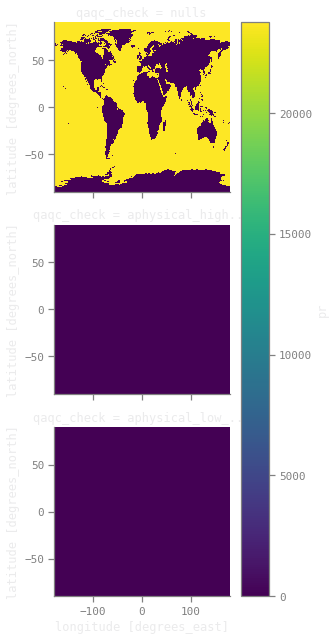

In [25]:
qaqc_maps['pr'].plot(col_wrap=1, col="qaqc_check")

What years, if any, include QAQC issues? Where, if anywhere, do those QAQC issues happen?

In [20]:
if run_qaqc:
    if annual_qaqc_ts.sum().values.any():
        print(annual_qaqc_ts)
        for var in qaqc_maps:
            if qaqc_maps[var].sum().values.any():
                qaqc_maps[var].plot(col_wrap=1, col="qaqc_check")

                        pr
year qaqc_check           
1950 nulls       253529000
1951 nulls       253529000
1952 nulls       254223600
1953 nulls       253529000
1954 nulls       253529000
...                    ...
2010 nulls       253529000
2011 nulls       253529000
2012 nulls       254223600
2013 nulls       253529000
2014 nulls       253529000

[65 rows x 1 columns]


ValueError: IndexVariable objects must be 1-dimensional

# Evaluation over training period

How well do statistics of downscaled GCM data look like observations? In other
words, did the model perform as expected and are there any other side-effects.


First, let's look at some individual locations around the world (we'll look at a
sampling of the biggest cities). We'll compare the statistics of the historical
downscaled data with the observations dataset and see how they match. Depending
on the metric they should align very well (if that metric was used in training)
but other metrics might differ still.


Load in the training dataset (ERA5)


We'll do our analyses across the 100 biggest cities (all in different countries
so as to provide some geographic diversity). Also added a few in the Western US
to cover that part of the world.


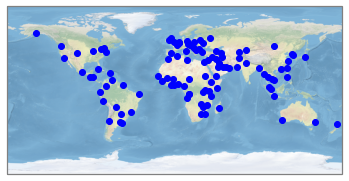

In [31]:
top_cities = load_top_cities(num_cities=100, add_additional_cities=True, plot=True)

In [48]:
if method == 'bcsd':
    [obs_cities, downscaled_cities, gcm_cities] = grab_top_city_data(
        [obs[var], output_daily[var], gcm_train[var]], top_cities
    )
# if historical then gcm_predict serves as the raw gcm
elif method == 'gard':
    [obs_cities, downscaled_cities, gcm_cities] = grab_top_city_data(
        [obs[var], output_daily[var], gcm_predict[var]], top_cities
    )

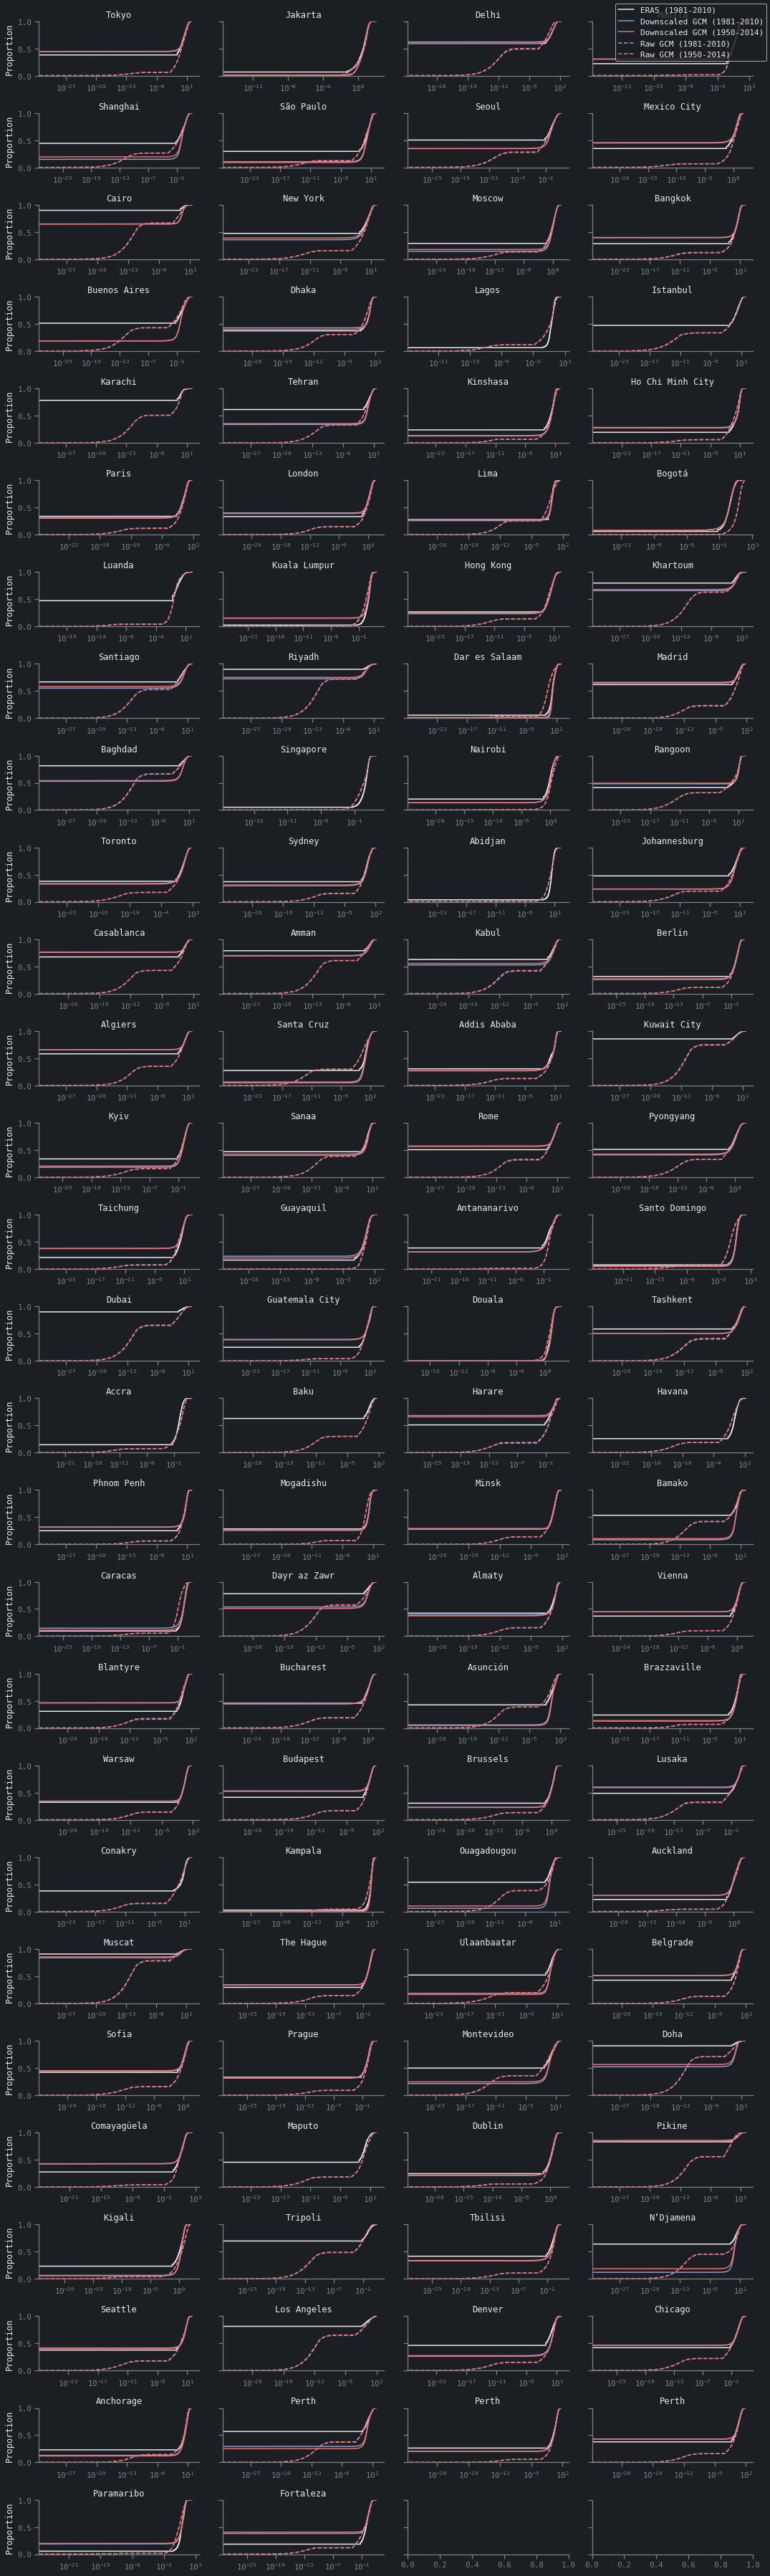

In [62]:
plot_cdfs(
    obs_cities,
    top_cities,
    train_period,
    predict_period,
    downscaled_cities.sel(time=train_period),
    downscaled_cities.sel(time=predict_period),
    gcm_cities.sel(time=train_period),
    gcm_cities.sel(time=predict_period),
    sharex=False,
    log_transform=True
)

# Performance of standard statistics


In [15]:
regions = {'US': {'lat': slice(25,50), 'lon': slice(-120, -70)},
           'tiny central US': {'lat': slice(35,40), 'lon': slice(-100, -90)},
           'Brazil': {'lat': slice(-30,10), 'lon': slice(-70,-30)}
          }

In [17]:
metric_dict = {'obs': {}, 'downscaled': {}}
for metric in ["mean", "median", "std"]:  # , 'percentile1',
    metric_dict['obs'][metric] = metrics.metric_calc(obs.sel(time=train_period), metric)[
        var
    ].compute()
    metric_dict['downscaled'][metric] = metrics.metric_calc(
        output_daily.sel(time=train_period), metric
    )[var].compute()

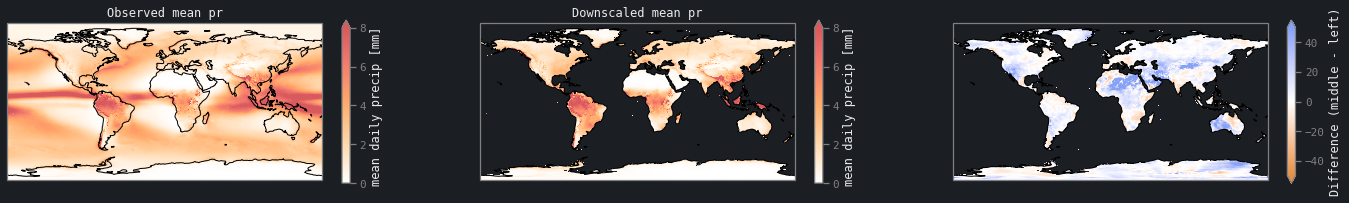

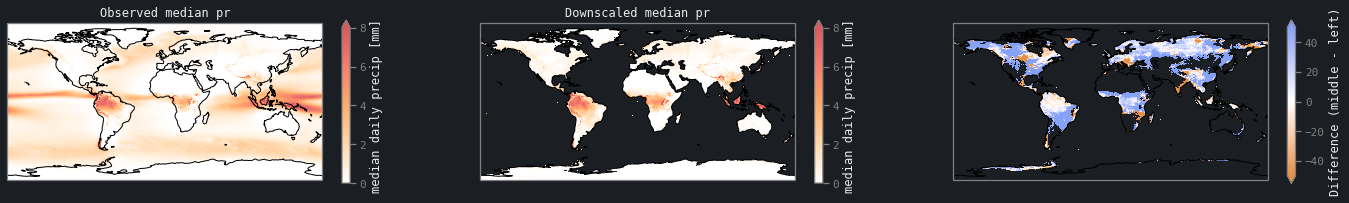

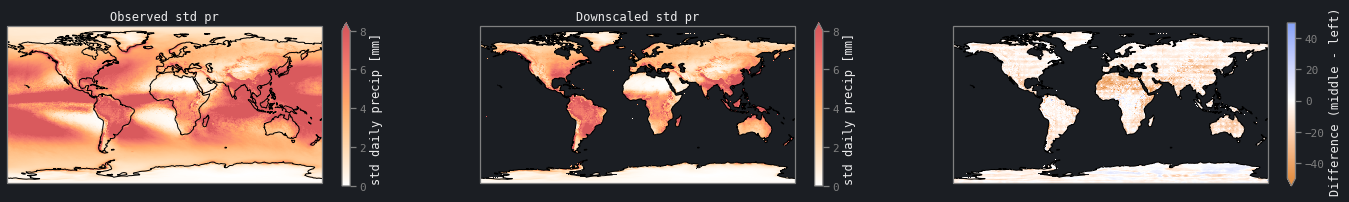

In [121]:
for metric in ["mean", "median", "std"]:  # , 'percentile1',
    # 'percentile5', 'percentile95', 'percentile99']:
    plot_values_and_difference(
        metric_dict['obs'][metric],
        metric_dict['downscaled'][metric],
        title1="Observed {} {}".format(metric, var),
        title2="Downscaled {} {}".format(metric, var),
        cbar_kwargs={"label": f"{metric} daily precip [mm]"},
        var_limits=(0,8),
        # title3="Difference downscaled-GCM",
        diff_limit=50,
        variable=var,
        metric=metric,
        diff_method='percent',
        cmap_diff='orangeblue_light'
    )

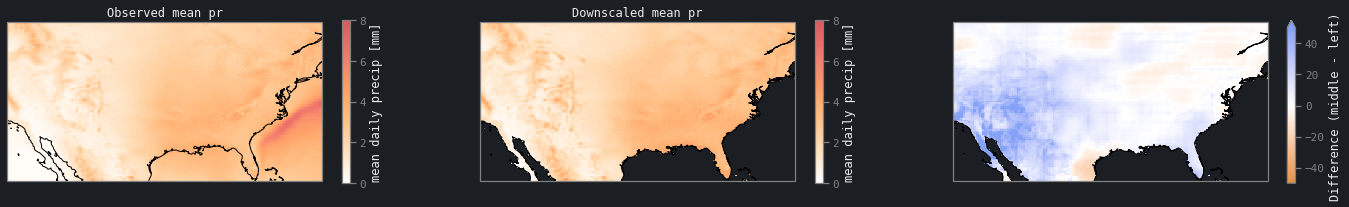

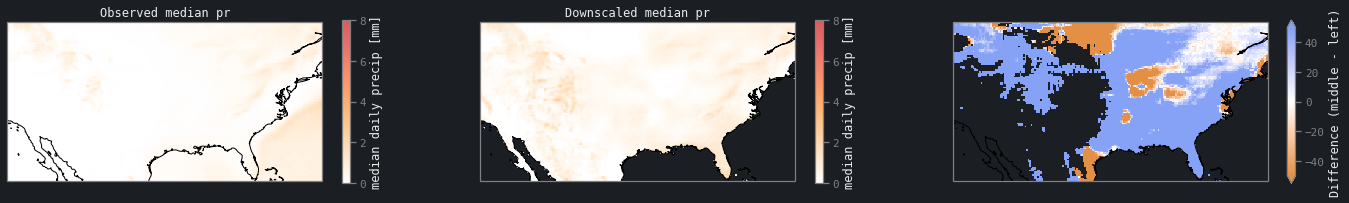

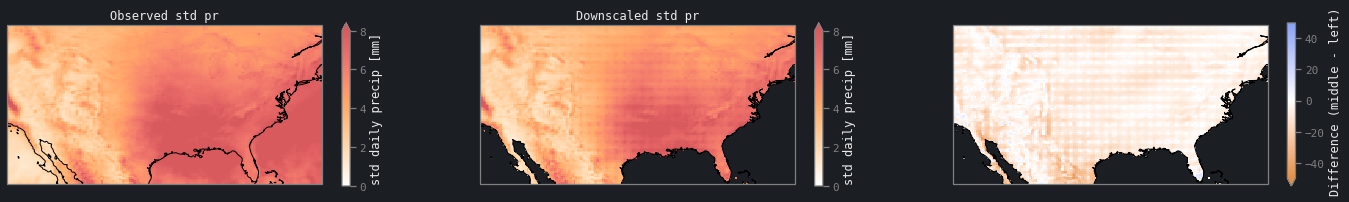

In [124]:
if var == "pr":
    for metric in ["mean", "median", "std"]:
        plot_values_and_difference(
            metric_dict['obs'][metric].sel(**regions['US']),
            metric_dict['downscaled'][metric].sel(**regions['US']),
            cbar_kwargs={"label": f"{metric} daily precip [mm]"},
            variable=var,
            var_limits=(0,8),
            # title3="Difference downscaled-GCM",
            title1="Observed {} {}".format(metric, var),
            title2="Downscaled {} {}".format(metric, var),
            diff_limit=50,
            diff_method='percent',
            cmap_diff='orangeblue_light'
        )

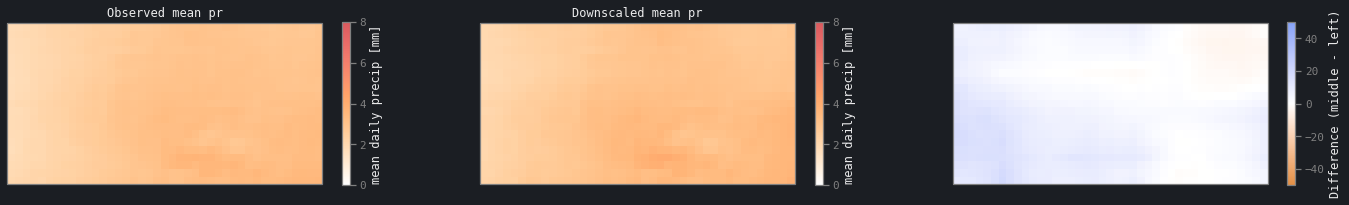

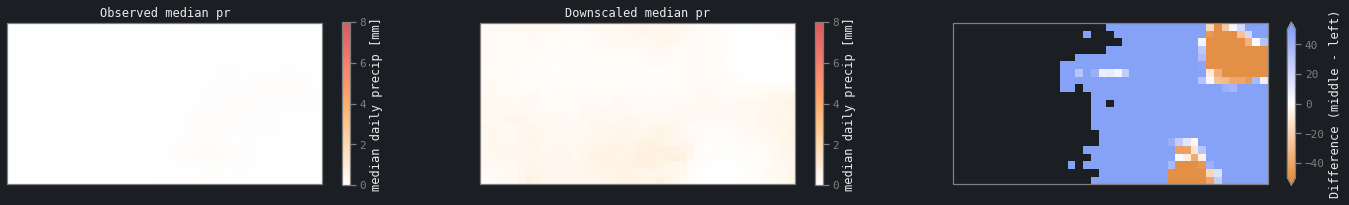

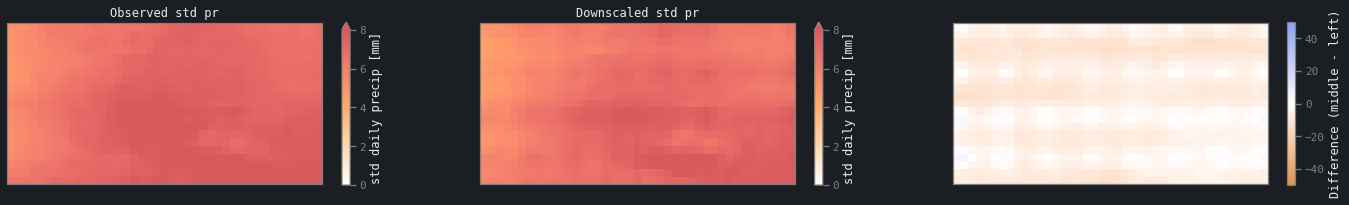

In [126]:
if var == "pr":
    for metric in ["mean", "median", "std"]:
        plot_values_and_difference(
            metric_dict['obs'][metric].sel(**regions['tiny central US']),
            metric_dict['downscaled'][metric].sel(**regions['tiny central US']),
            cbar_kwargs={"label": f"{metric} daily precip [mm]"},
            variable=var,
            var_limits=(0,8),
            title1="Observed {} {}".format(metric, var),
            title2="Downscaled {} {}".format(metric, var),
            diff_limit=50,
            diff_method='percent',
            cmap_diff='orangeblue_light'
        )

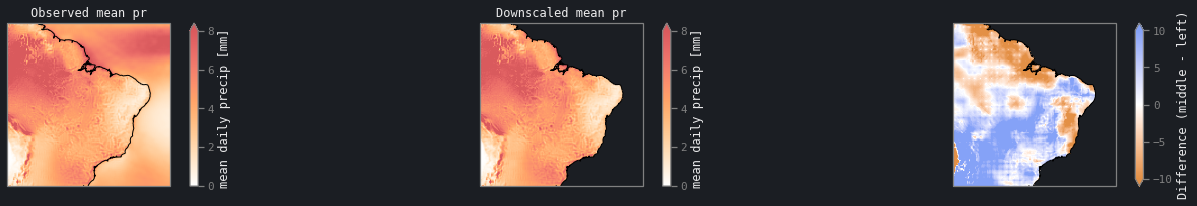

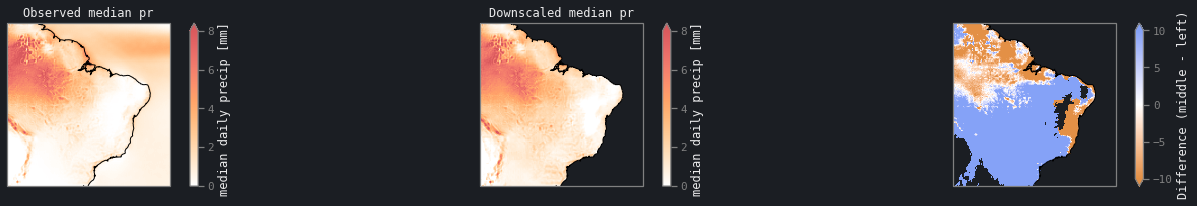

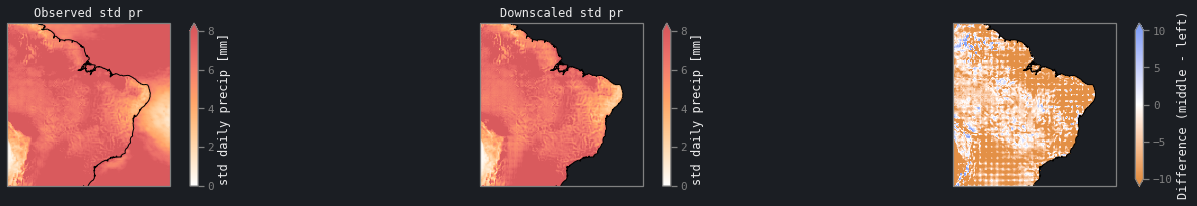

In [128]:
if var == "pr":
    for metric in ["mean", "median", "std"]:
        plot_values_and_difference(
            metric_dict['obs'][metric].sel(**regions['Brazil']),
            metric_dict['downscaled'][metric].sel(**regions['Brazil']),
            cbar_kwargs={"label": f"{metric} daily precip [mm]"},
            title1="Observed {} {}".format(metric, var),
            title2="Downscaled {} {}".format(metric, var),
            diff_limit=10,
            diff_method='percent',
            cmap_diff='orangeblue_light',
            variable=var,
            var_limits=(0,8),
        )

In [141]:
output_daily.sel(time=slice('1981', '2010'))

<xarray.Dataset>
Dimensions:  (lat: 721, lon: 1440, time: 10957)
Coordinates:
  * lat      (lat) float32 -90.0 -89.75 -89.5 -89.25 ... 89.25 89.5 89.75 90.0
  * lon      (lon) float32 -180.0 -179.8 -179.5 -179.2 ... 179.2 179.5 179.8
  * time     (time) datetime64[ns] 1981-01-01 1981-01-02 ... 2010-12-31
Data variables:
    pr       (time, lat, lon) float32 dask.array<chunksize=(10957, 48, 48), meta=np.ndarray>
Attributes:
    history:      Created: Thu Jun  9 02:08:07 2022
    hostname:     jupyter-norlandrhagen--sk-5fdownscale-5ftest
    institution:  CarbonPlan
    source:       /srv/conda/envs/notebook/bin/prefect
    title:        gard_fit_and_predict
    username:     norlandrhagen
    version:      0.1.7

2022-06-14 21:13:53,176 - distributed.nanny - WARNING - Restarting worker
2022-06-14 21:13:53,195 - distributed.nanny - WARNING - Restarting worker
2022-06-14 21:13:53,479 - distributed.nanny - WARNING - Restarting worker
2022-06-14 21:13:53,482 - distributed.nanny - WARNING - Restarting worker
2022-06-14 21:13:53,569 - distributed.nanny - WARNING - Restarting worker
2022-06-14 21:13:53,651 - distributed.nanny - WARNING - Restarting worker
2022-06-14 21:13:53,659 - distributed.nanny - WARNING - Restarting worker
2022-06-14 21:13:53,832 - distributed.nanny - WARNING - Restarting worker
2022-06-14 21:13:53,920 - distributed.nanny - WARNING - Restarting worker
2022-06-14 21:13:53,924 - distributed.nanny - WARNING - Restarting worker
2022-06-14 21:13:54,136 - distributed.nanny - WARNING - Restarting worker
2022-06-14 21:13:54,255 - distributed.nanny - WARNING - Restarting worker
2022-06-14 21:13:54,363 - distributed.nanny - WARNING - Restarting worker
2022-06-14 21:13:54,474 - distributed.

In [16]:
scrf = xr.open_zarr('az://static/scrf/ERA5_pr_1981_1990.zarr')

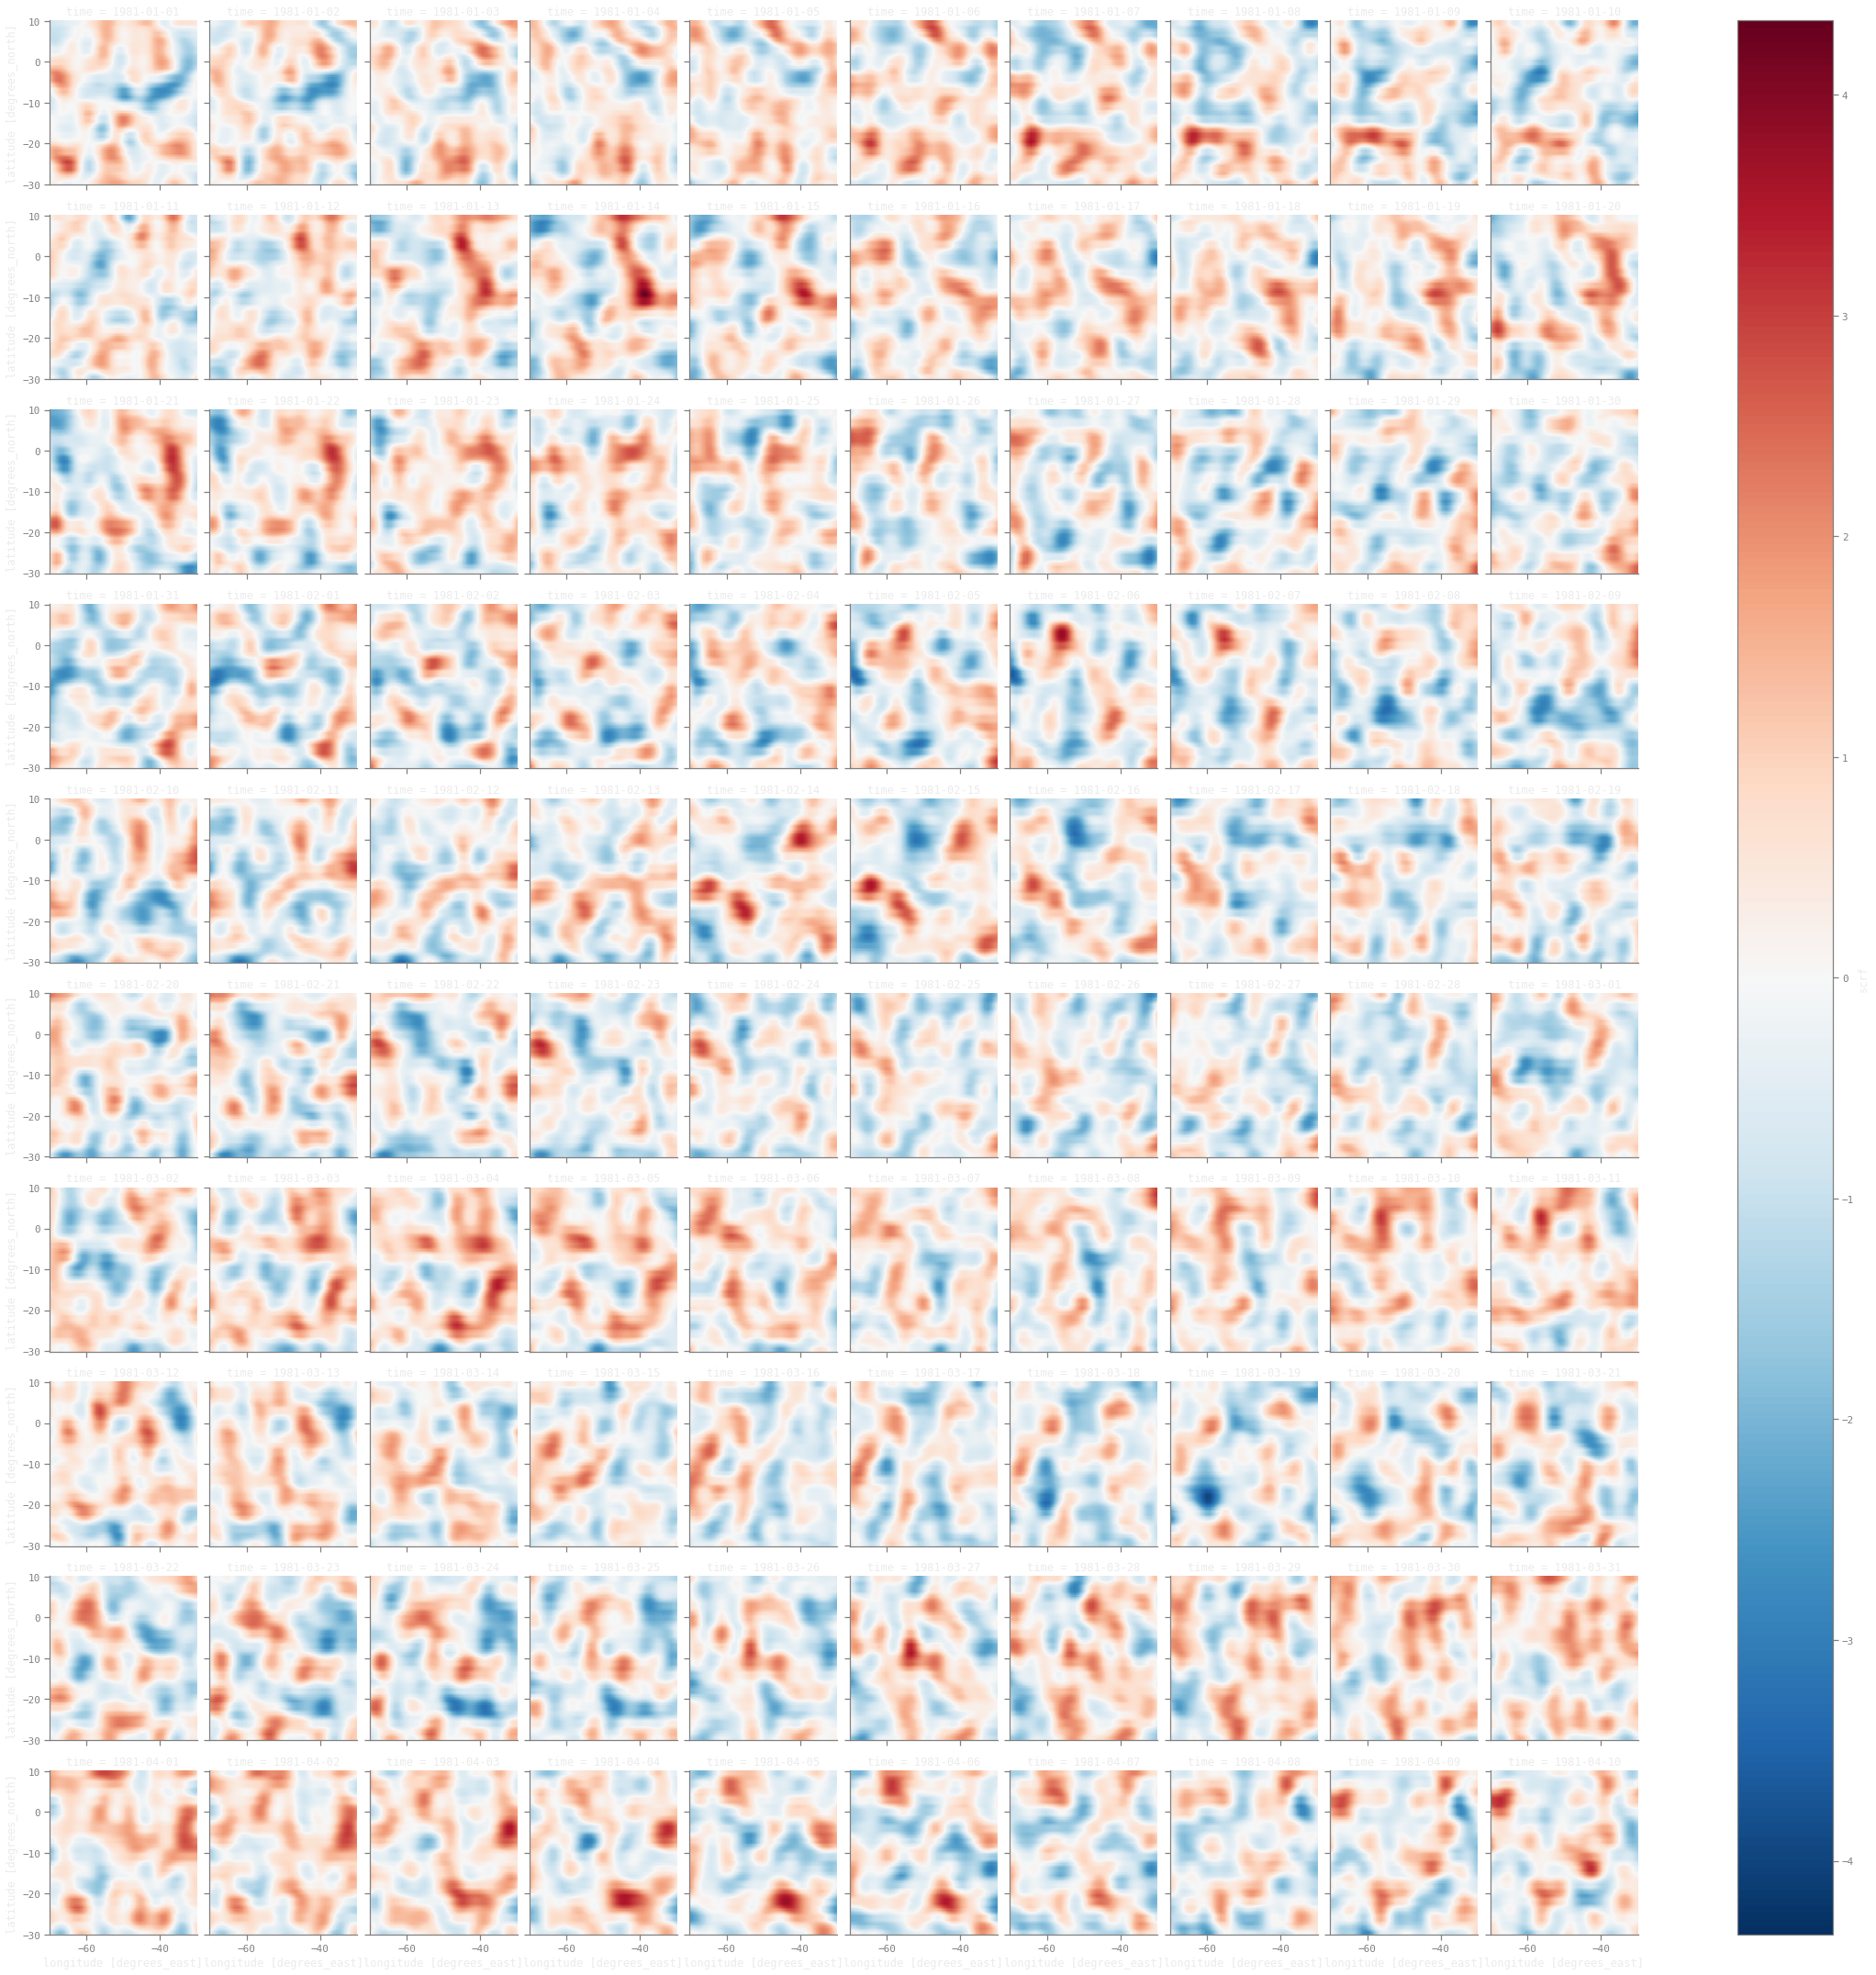

In [17]:
scrf.sel(**regions['Brazil']).isel(time=slice(0,100)).scrf.plot(col='time', col_wrap=10)

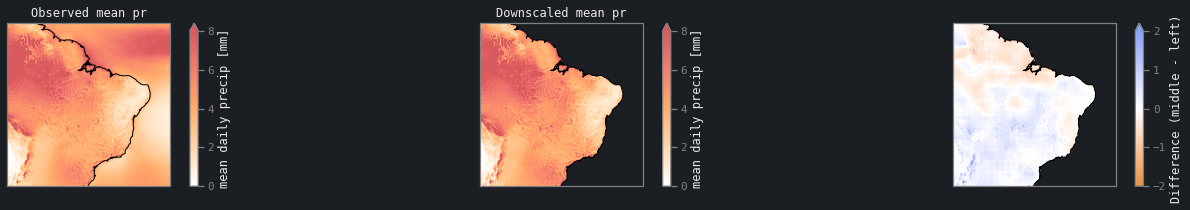

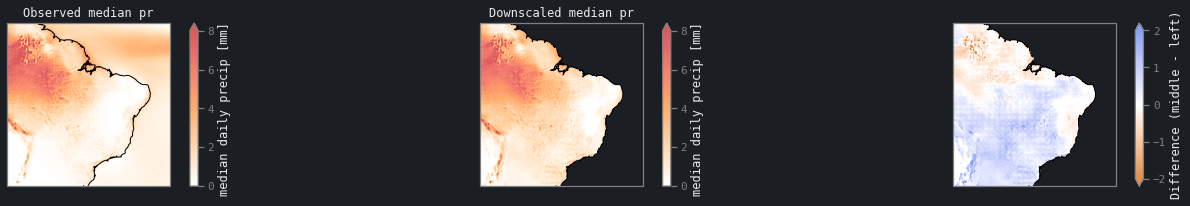

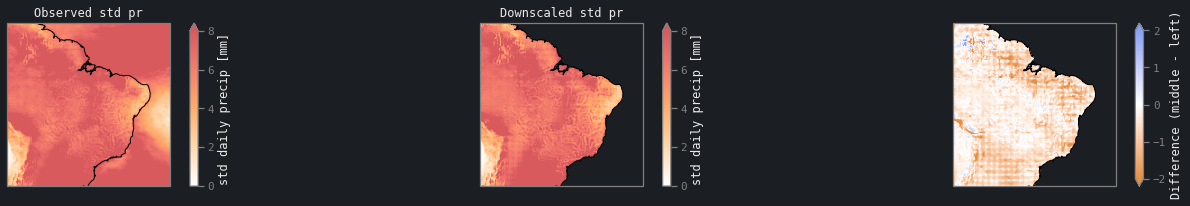

In [130]:
if var == "pr":
    for metric in ["mean", "median", "std"]:
        plot_values_and_difference(
            metric_dict['obs'][metric].sel(**regions['Brazil']),
            metric_dict['downscaled'][metric].sel(**regions['Brazil']),
            cbar_kwargs={"label": f"{metric} daily precip [mm]"},
            title1="Observed {} {}".format(metric, var),
            title2="Downscaled {} {}".format(metric, var),
            diff_limit=2,
            diff_method='absolute',
            cmap_diff='orangeblue_light',
            variable=var,
            var_limits=(0,8),
        )

# Hot days

Calculate the average number of hot days (over 30c) within observations and
downscaled model.


In [ ]:
if var == "tasmax":
    days_over_30c_era5 = metrics.days_temperature_threshold(obs_ds, "over", 273 + 30).compute()
    days_over_30c_ds = metrics.days_temperature_threshold(
        ds.sel(time=train_period), "over", 273 + 30
    ).compute()
    plot_values_and_difference(
        days_over_30c_era5["tasmax"],
        days_over_30c_ds["tasmax"],
        cbar_kwargs={"label": "Days over 30C"},
        diff_limit=20,
    )

# Very hot days

Performance: the average number of very hot days (over 40c)


In [ ]:
if var == "tasmax":
    days_over_40c_era5 = metrics.days_temperature_threshold(obs_ds, "over", 273 + 40).compute()
    days_over_40c_ds = metrics.days_temperature_threshold(
        ds.sel(time=train_period), "over", 273 + 40
    ).compute()
    plot_values_and_difference(
        days_over_40c_era5["tasmax"],
        days_over_40c_ds["tasmax"],
        title1="Observed days per year over 30C",
        title2="Downscaled days per year over 30C",
        cbar_kwargs={"label": "Days over 40C"},
    )

# Is the change seen in the downscaled dataset the same as the change projected by the raw GCM?


In [ ]:
downscaled_change_cities = change_ds(
    downscaled_cities.sel(time=train_period),
    downscaled_cities.sel(time=future_period),
)
gcm_change_cities = change_ds(gcm_cities.sel(time=train_period), gcm_cities.sel(time=future_period))

In [ ]:
for metric in gcm_change_cities:
    plot_values_and_difference(
        gcm_change_cities[metric],
        downscaled_change_cities[metric],
        gcm_change_cities,
        city_coords=obs_cities,
        title1="GCM change in {}".format(metric),
        title2="Downscaled change in {}".format(metric),
        title3="Difference downscaled-GCM",
        variable=var,
        metric=metric,
    )

# Seasonal statistics


### Assess the mean value over the season


In [65]:
aggregator = "mean"
obs_seasonal = get_seasonal(obs, aggregator=aggregator)
downscaled_seasonal = get_seasonal(output_daily.sel(time=train_period), aggregator=aggregator)

In [69]:
cmap_diff_dict = {'pr': 'orangeblue_light',
                  'tasmax': 'orangeblue_light_r',
                  'tasmin': 'orangeblue_light_r'}

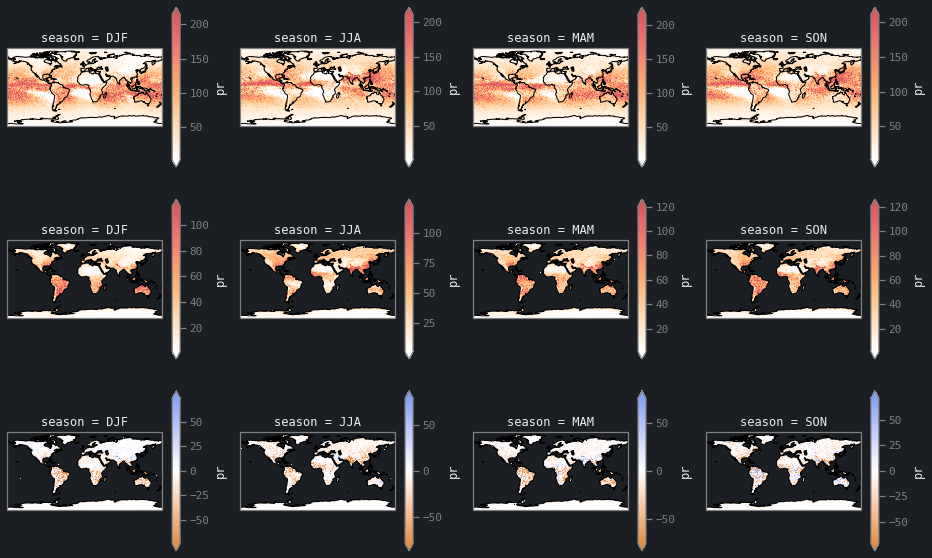

In [70]:
plot_seasonal(obs_seasonal[var], downscaled_seasonal[var], cmap_diff=cmap_diff_dict[var])

### Assess the max value over the season


/srv/conda/envs/notebook/lib/python3.9/site-packages/dask/array/reductions.py:608: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
/srv/conda/envs/notebook/lib/python3.9/site-packages/dask/array/reductions.py:608: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
/srv/conda/envs/notebook/lib/python3.9/site-packages/dask/array/reductions.py:608: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
/srv/conda/envs/notebook/lib/python3.9/site-packages/dask/array/reductions.py:608: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
/srv/conda/envs/notebook/lib/python3.9/site-packages/dask/array/reductions.py:608: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
/srv/conda/envs/notebook/lib/python3.9/site-packages/dask/array/reductions.py:608: Ru

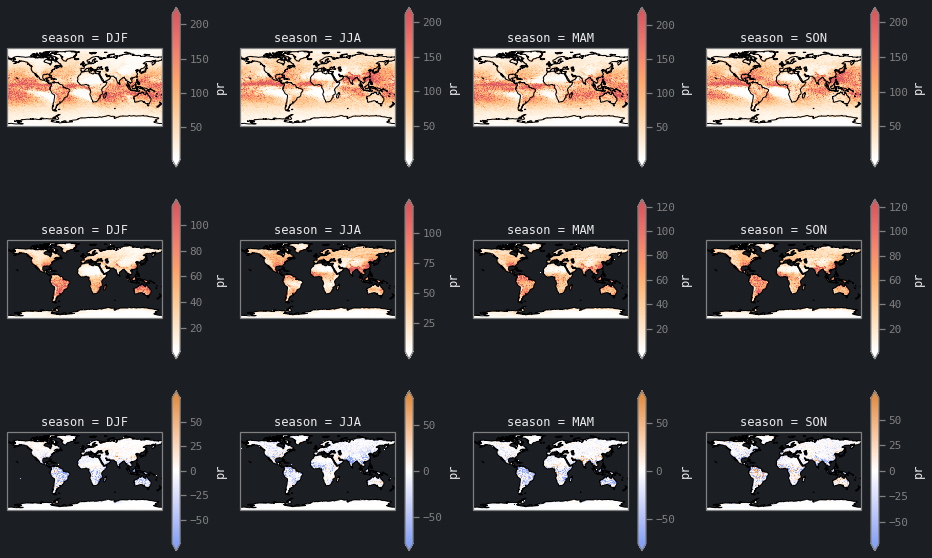

In [68]:
aggregator = "max"
obs_seasonal = get_seasonal(obs, aggregator=aggregator)
downscaled_seasonal = get_seasonal(output_daily.sel(time=train_period), aggregator=aggregator)
plot_seasonal(obs_seasonal[var], downscaled_seasonal[var])

### Assess the variability over the season


/srv/conda/envs/notebook/lib/python3.9/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.9/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.9/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.9/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.9/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.9/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.

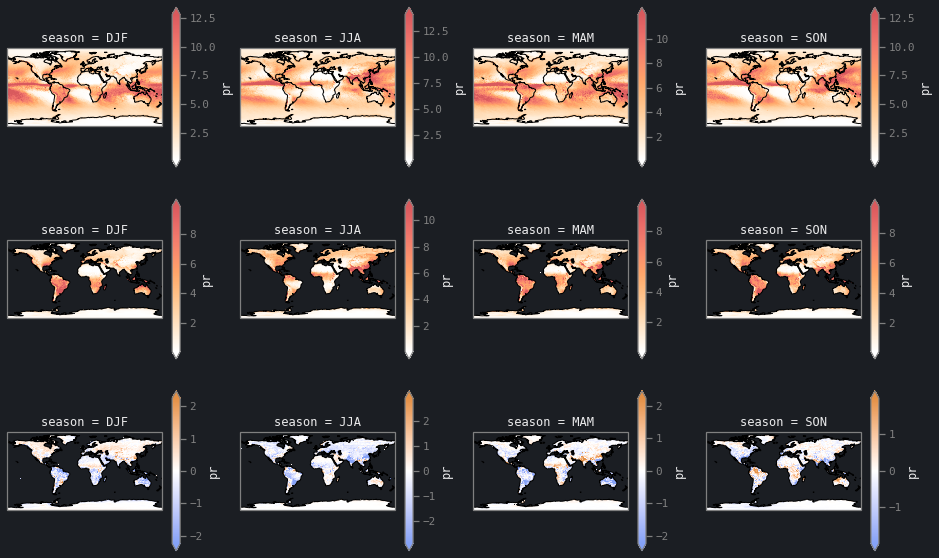

In [73]:
aggregator = "std"
obs_seasonal = get_seasonal(obs, aggregator=aggregator)
downscaled_seasonal = get_seasonal(output_daily.sel(time=train_period), aggregator=aggregator)
plot_seasonal(obs_seasonal[var], downscaled_seasonal[var])

# Precipitation-specific metrics


If precipitation, calculate the precipitation indices across season and plot the
same seasonal comparison maps. Metrics taken from Wilby 1998.


### If it was wet, how wet was it?


In [18]:
if var == "pr":
    wet_day_dict = {'obs': {},
                   'downscaled': {}}
    for metric in ["mean", "median", "std", "percentile95"]:
        wet_day_dict['obs'][metric] = metrics.wet_day_amount(obs, method=metric)['pr'].compute()
        wet_day_dict['downscaled'][metric] = metrics.wet_day_amount(output_daily.sel(time=train_period), method=metric)['pr'].compute()

/srv/conda/envs/notebook/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1096: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)
/srv/conda/envs/notebook/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1096: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)
/srv/conda/envs/notebook/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1096: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)
/srv/conda/envs/notebook/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1096: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)
/srv/conda/envs/notebook/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1096: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)
/srv/conda

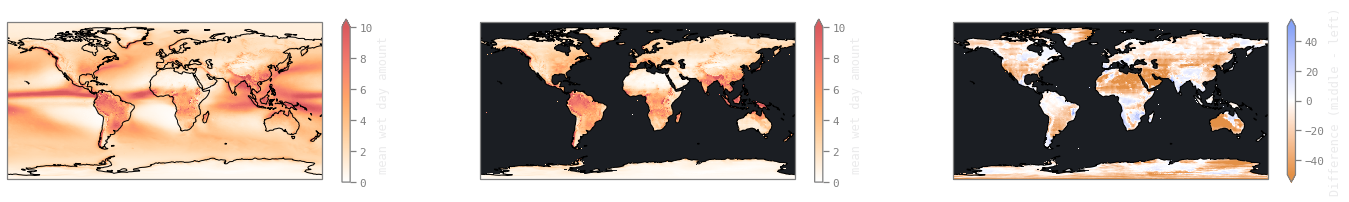

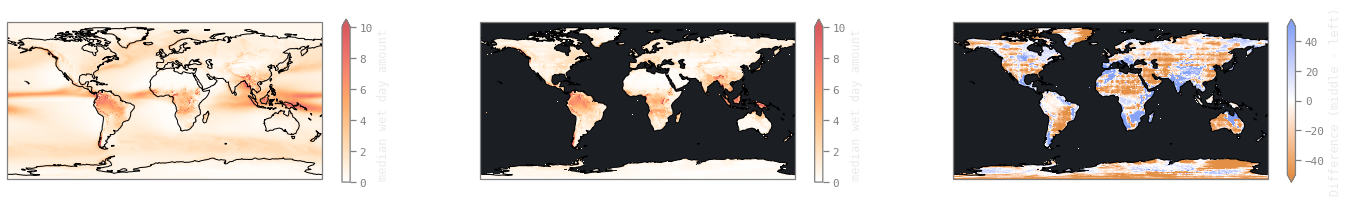

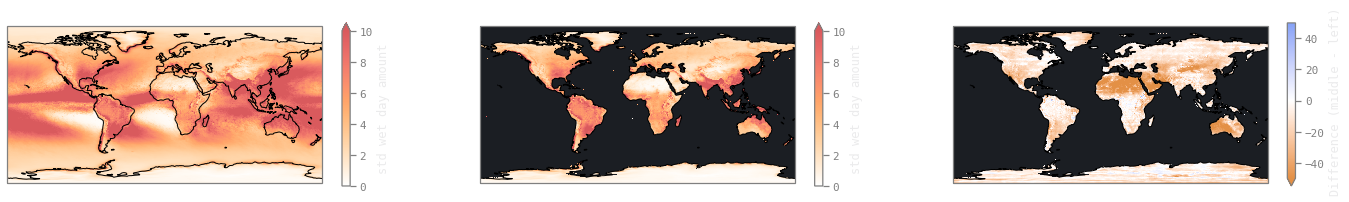

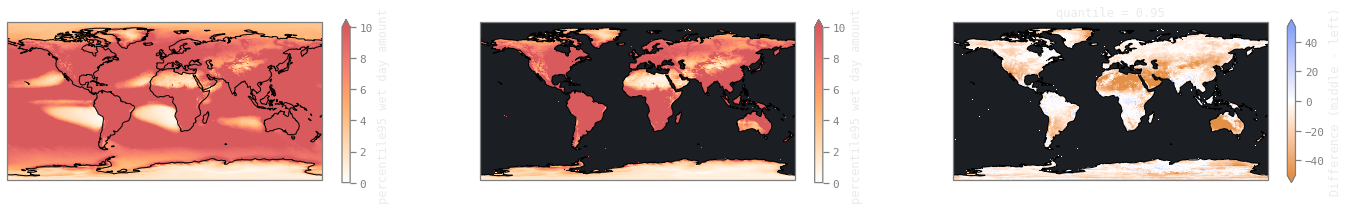

In [21]:
if var == "pr":
    for metric in ["mean", "median", "std", "percentile95"]:
        plot_values_and_difference(
            wet_day_dict['obs'][metric],
            wet_day_dict['downscaled'][metric],
            cbar_kwargs={"label": f"{metric} wet day amount"},
            diff_limit=50,
            diff_method='percent',
            cmap_diff='orangeblue_light',
            variable=var,
        )

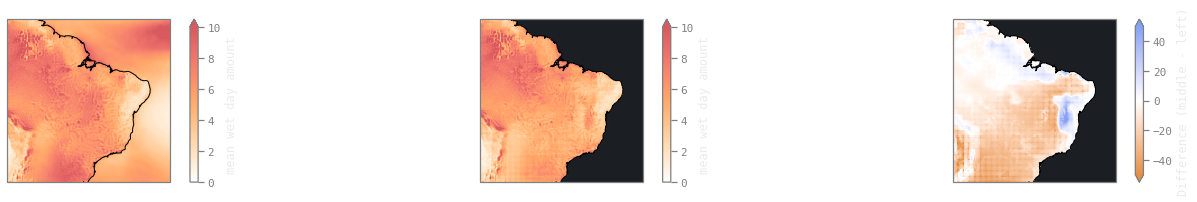

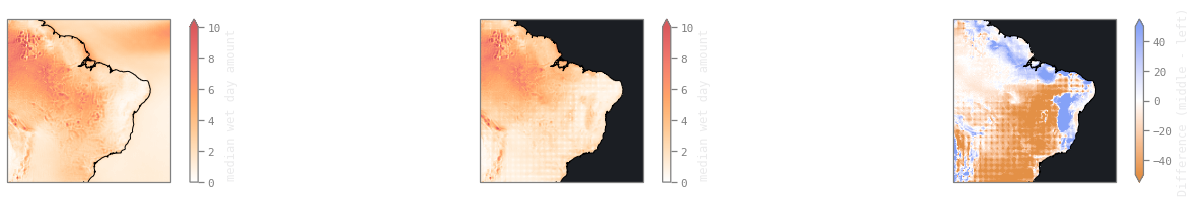

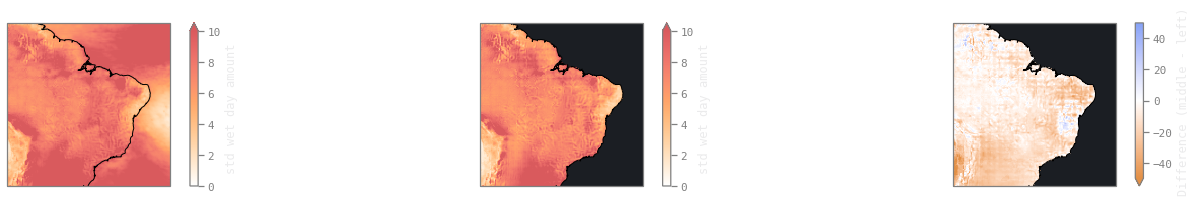

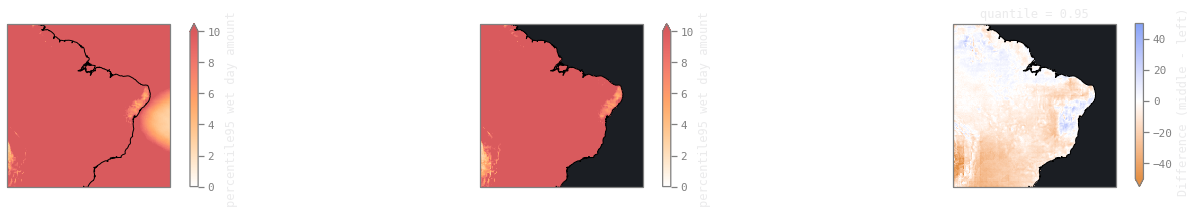

In [23]:
if var == "pr":
    for metric in ["mean", "median", "std", "percentile95"]:
        plot_values_and_difference(
            wet_day_dict['obs'][metric].sel(**regions['Brazil']),
            wet_day_dict['downscaled'][metric].sel(**regions['Brazil']),
            cbar_kwargs={"label": f"{metric} wet day amount"},
            diff_limit=50,
            diff_method='percent',
            cmap_diff='orangeblue_light',
            variable=var
        )

In [73]:
def plotting_positions(n, alpha=0.4, beta=0.4):
    '''Returns a monotonic array of plotting positions.
    Parameters
    ----------
    n : int
        Length of plotting positions to return.
    alpha, beta : float
        Plotting positions parameter. Default is 0.4.
    Returns
    -------
    positions : ndarray
        Quantile mapped data with shape from `input_data` and probability
            distribution from `data_to_match`.
    See Also
    --------
    scipy.stats.mstats.plotting_positions
    '''
    return (np.arange(1, n + 1) - alpha) / (n + 1. - alpha - beta)

In [74]:
def plot_cdf(x, **kwargs):
    
    pps = plotting_positions(len(x))
    xs = np.sort(x)
    
    return plt.plot(pps, xs, **kwargs)

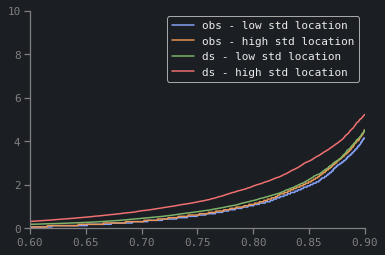

In [81]:
low_std_location = {'lat': 33, 'lon': -101.25}
high_std_location = {'lat': 33.5, 'lon': -100.75}
plot_cdf(obs.sel(**low_std_location).pr.values, label='obs - low std location')
plot_cdf(obs.sel(**high_std_location).pr.values, label='obs - high std location')
plot_cdf(output_daily.sel(time=train_period).sel(**low_std_location).pr.values, label='ds - low std location')
plot_cdf(output_daily.sel(time=train_period).sel(**high_std_location).pr.values, label='ds - high std location')
plt.xlim(0.6, 0.9)
plt.ylim(0,10)
plt.legend()

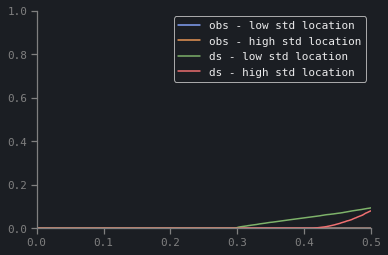

In [82]:
plot_cdf(obs.sel(**low_std_location).pr.values, label='obs - low std location')
plot_cdf(obs.sel(**high_std_location).pr.values, label='obs - high std location')
plot_cdf(output_daily.sel(time=train_period).sel(**low_std_location).pr.values, label='ds - low std location')
plot_cdf(output_daily.sel(time=train_period).sel(**high_std_location).pr.values, label='ds - high std location')
plt.xlim(0, 0.5)
plt.ylim(0,1)
plt.legend()

Task exception was never retrieved
future: <Task finished name='Task-15532' coro=<Client._gather.<locals>.wait() done, defined at /srv/conda/envs/notebook/lib/python3.9/site-packages/distributed/client.py:2016> exception=AllExit()>
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.9/site-packages/distributed/client.py", line 2025, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-15533' coro=<Client._gather.<locals>.wait() done, defined at /srv/conda/envs/notebook/lib/python3.9/site-packages/distributed/client.py:2016> exception=AllExit()>
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.9/site-packages/distributed/client.py", line 2025, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-15534' coro=<Client._gather.<locals>.wait() done, defined at /srv/conda/envs/notebook/lib/pytho

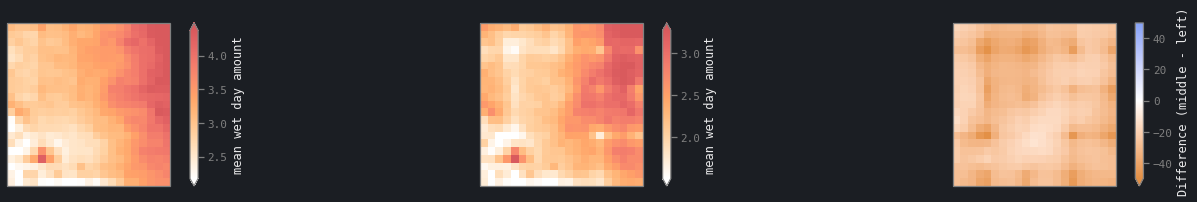

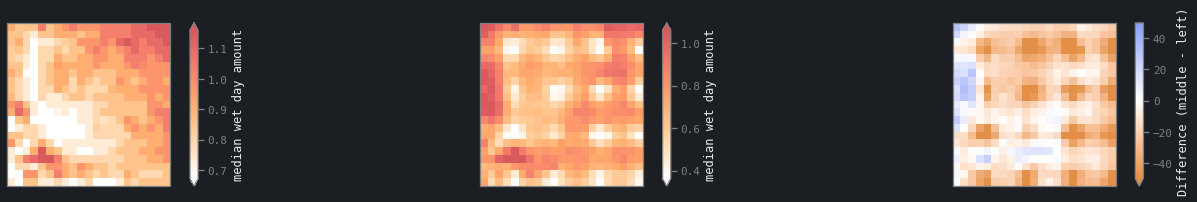

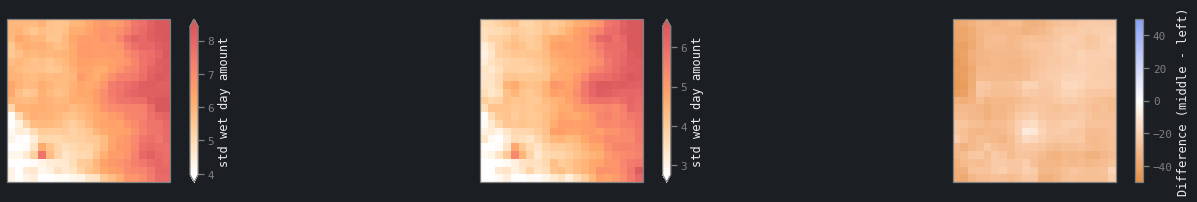

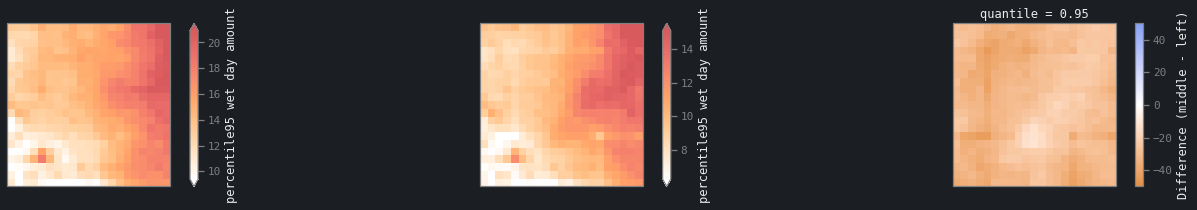

In [56]:
if var == "pr":
    for metric in ["mean", "median", "std", "percentile95"]:
        plot_values_and_difference(
            wet_day_dict['obs'][metric].sel(lat=slice(30,35), lon=slice(-105, -100)),#.sel(lat=slice(25,50), lon=slice(-120, -70)),
            wet_day_dict['downscaled'][metric].sel(lat=slice(30,35), lon=slice(-105, -100)),#.sel(lat=slice(25,50), lon=slice(-120, -70)),
            cbar_kwargs={"label": f"{metric} wet day amount"},
            diff_limit=50,
            diff_method='percent',
            cmap_diff='orangeblue_light'
        )

In [ ]:
difference_dict = {}
difference = (((metric_dict['downscaled']['std'] - metric_dict['obs']['std'])/metric_dict['obs']['std'])*100).compute()

Calculate boolean masks of wet and dry days (they are inverses of eachother)
based upon a threshold. We'll then use these to perform a variety of statistics.


In [24]:
if var == "pr":
    wet_days_obs = metrics.is_wet_day(obs, threshold=0.0).compute()
    dry_days_obs = ~wet_days_obs
    wet_days_downscaled = metrics.is_wet_day(output_daily.sel(time=train_period), threshold=0.0).compute()
    dry_days_downscaled = ~wet_days_downscaled

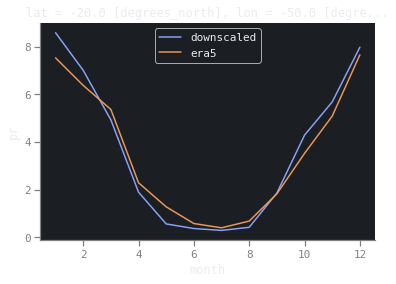

In [42]:
output_daily.sel(**brazil_location).groupby('time.month').mean().pr.plot(label='downscaled')
obs.sel(**brazil_location).groupby('time.month').mean().pr.plot(label='era5')
plt.legend()

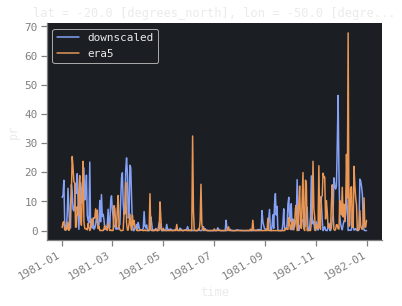

In [41]:
output_daily.sel(**brazil_location).sel(time=slice('1981', '1981')).pr.plot(label='downscaled')
obs.sel(**brazil_location).sel(time=slice('1981', '1981')).pr.plot(label='era5')
plt.legend()

In [38]:
seattle = {'lat': 47.5, 'lon': -121.75}
brazil_location = {'lat': -20, 'lon': -50}
# 'lat': slice(-30,10), 'lon': slice(-70,-30)}

In [39]:
wet_day_obs_count.sel(**brazil_location).pr.values

array(220.96666667)

In [40]:
wet_day_downscaled_count.sel(**brazil_location).pr.values

array(313.7)

In [25]:
wet_day_obs_count = wet_days_obs.groupby('time.year').sum().mean(dim='year').compute()
wet_day_downscaled_count = wet_days_downscaled.groupby('time.year').sum().mean(dim='year').compute()

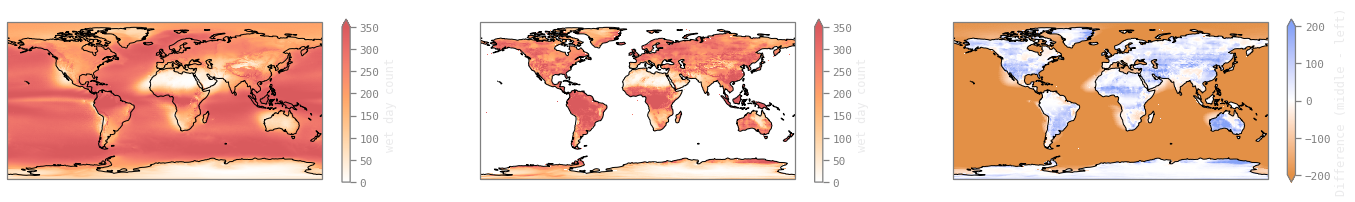

In [26]:
plot_values_and_difference(
            wet_day_obs_count.pr,
            wet_day_downscaled_count.pr,
            cbar_kwargs={"label": "wet day count"},
            diff_limit=200,
            var_limits=(0,350),
            diff_method='absolute',
            cmap_diff='orangeblue_light',
                variable=var

        )

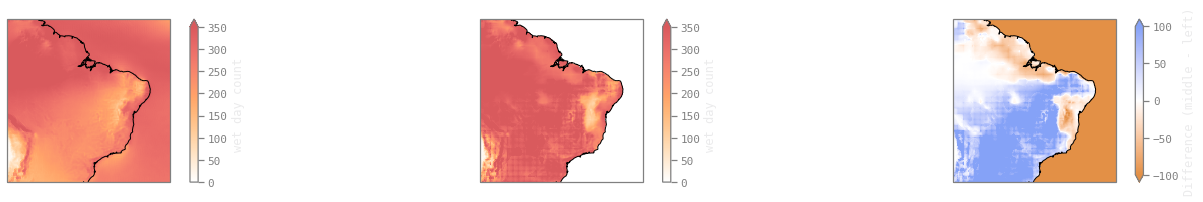

In [27]:
plot_values_and_difference(
            wet_day_obs_count.pr.sel(**regions['Brazil']),
            wet_day_downscaled_count.pr.sel(**regions['Brazil']),
            cbar_kwargs={"label": f"wet day count"},
            var_limits=(0,350),
            diff_limit=100,
            diff_method='absolute',
            cmap_diff='orangeblue_light',
            variable=var
        )

### Length and variability of wet spells


In [ ]:
if var == "pr":
    for metric in ["mean", "std", "percentile90", "percentile99"]:
        plot_values_and_difference(
            apply_spell_length(wet_days_obs, metric),
            apply_spell_length(wet_days_downscaled, metric),
            cbar_kwargs={"label": f"{metric} days"},
            diff_limit=10,
        )

### Length and variability of dry spells


In [ ]:
if var == "pr":
    for metric in ["mean", "std", "percentile90", "percentile99"]:
        plot_values_and_difference(
            apply_spell_length(dry_days_obs, metric),
            apply_spell_length(dry_days_downscaled, metric),
            cbar_kwargs={"label": f"{metric} days"},
            diff_limit=10,
        )

### If today was wet, what are odds tomorrow will be wet?


In [ ]:
if var == "pr":
    plot_values_and_difference(
        metrics.probability_two_consecutive_days(obs_ds, kind_of_days="wet")["pr"],
        metrics.probability_two_consecutive_days(ds.sel(time=train_period), kind_of_days="wet")[
            "pr"
        ],
        cbar_kwargs={"label": "probability"},
        diff_limit=0.5,
    )

### If today was dry, what are odds tomorrow will be dry?


In [ ]:
if var == "pr":
    plot_values_and_difference(
        metrics.probability_two_consecutive_days(obs_ds, kind_of_days="dry")["pr"],
        metrics.probability_two_consecutive_days(ds.sel(time=train_period), kind_of_days="dry")[
            "pr"
        ],
        cbar_kwargs={"label": "probability"},
        diff_limit=0.5,
    )

### Low frequency variability - standard deviation of monthly precipitation


In [ ]:
if var == "pr":
    plot_values_and_difference(
        monthly_variability(obs_ds.pr, method="sum"),
        monthly_variability(ds.sel(time=train_period).pr, method="sum"),
        cbar_kwargs={"label": "mm"},
        diff_limit=0.5,
    )